AS.430.271.81: M03 - Adam Thomas

# M03 Homework
This JupyterLab Notebook will implement the following tasks:
- Download 1Million NYC taxi from hereLinks to an external site.
- Unzip the file
- Load it into a Pandas data frame
- Find the missing string values and replace them with ‘N/A’
- Find the missing numerical values and replace them with 0
- Filter the data geographically to be in the Manhattan area.
- Show in a graph the number of pickups by the hour, where x axis is the hour
- Filter the data geographically to be around JFK
- Show in a graph the number of dropoffs with more than 2 passengers after 7PM, where x axis is the hour
- Create a function that projects the coordinates to web Mercator and apply that function to create 4 new fields for pickup and dropoff locations
- Create a function that calculates the Euclidean distance between web Mercator pickup and drop-offs
- Plot Euclidian distance distribution where distance is less than 20 kilometers.
- GeoEnrich pickup and dropoff locations with zip code polygo
- Upload a jupyter notebook to the link above.


In [1]:
import colorcet
import contextily
import datashader
import geopandas
import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn

# Set default map source for contextily
map_source = 'https://api.mapbox.com/styles/v1/mapbox/dark-v11/tiles/{z}/{x}/{y}?access_token=pk.eyJ1IjoiYW10aG9tYXMiLCJhIjoiY2xkcDkzbzQwMHh5bTN1a2R3MGlydnN6ZyJ9.uQjZh-jqKwgLX7alCt2foQ'

## Load and Inspect input data

In [2]:
trips_1M = pandas.read_csv('trips-1M.csv')

Let's take a look at the structure of the data

In [3]:
trips_1M.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   medallion  999999 non-null  object 
 1   license    999999 non-null  object 
 2   vendor     999999 non-null  object 
 3   rate_cd    999999 non-null  int64  
 4   flag       3535 non-null    object 
 5   pdate      999999 non-null  object 
 6   ddate      999999 non-null  object 
 7   passcount  999999 non-null  int64  
 8   triptime   999999 non-null  int64  
 9   tripdist   999999 non-null  float64
 10  plon       999999 non-null  float64
 11  plat       999999 non-null  float64
 12  dlon       999999 non-null  float64
 13  dlat       999999 non-null  float64
dtypes: float64(5), int64(3), object(6)
memory usage: 106.8+ MB


Firstly, let's convert date fields into dates and object fields into strings

In [4]:
trips_1M[['pdate', 'ddate']] = trips_1M[['pdate', 'ddate']].apply(pandas.to_datetime)
trips_1M[['medallion', 'license', 'vendor', 'flag']] = trips_1M[['medallion', 'license', 'vendor', 'flag']].astype("string")

Secondly, let's fill the 996464 null _flag_ values with 'N/A'

In [5]:
trips_1M = trips_1M.fillna('N/A')

Thirdly, let's take another look at the data structure.

In [6]:
trips_1M.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   medallion  999999 non-null  string        
 1   license    999999 non-null  string        
 2   vendor     999999 non-null  string        
 3   rate_cd    999999 non-null  int64         
 4   flag       999999 non-null  string        
 5   pdate      999999 non-null  datetime64[ns]
 6   ddate      999999 non-null  datetime64[ns]
 7   passcount  999999 non-null  int64         
 8   triptime   999999 non-null  int64         
 9   tripdist   999999 non-null  float64       
 10  plon       999999 non-null  float64       
 11  plat       999999 non-null  float64       
 12  dlon       999999 non-null  float64       
 13  dlat       999999 non-null  float64       
dtypes: datetime64[ns](2), float64(5), int64(3), string(4)
memory usage: 106.8 MB


## Clip data to within NY land boundary

From a previous assignment I saw that some taxi records were in the water. Therefore I will filter these using a geopandas dataframe and a high resolution state shoreline shapefile.

In [7]:
land_boundary = geopandas.read_file('State_Shorline_LL84.shp')

# Clip both the pickup and dropoff locations to the New York State shoreline
temp_gdf = geopandas.GeoDataFrame(trips_1M, geometry=geopandas.points_from_xy(trips_1M.plon, trips_1M.plat), crs=f"EPSG:4326").clip(land_boundary)
final_gdf = geopandas.GeoDataFrame(temp_gdf, geometry=geopandas.points_from_xy(temp_gdf.dlon, temp_gdf.dlat), crs=f"EPSG:4326").clip(land_boundary)


## Filter Data to within Manhatten

Using bounding box coordinates from: http://bboxfinder.com/#40.699511,-74.020214,40.777422,-73.941250
Also remove and locations where the pickup and dropoff location are the same for a single journey (a possible invalid trip?)

In [8]:
xmin,xmax,ymin,ymax = [-74.020214,-73.941250,40.699511,40.777422]
manhatten_df = final_gdf[(final_gdf['plat'].between(ymin,ymax)) & 
                         (final_gdf['plon'].between(xmin,xmax)) & 
                         (final_gdf['dlat'].between(ymin,ymax)) & 
                         (final_gdf['dlon'].between(xmin,xmax)) &
                         ((final_gdf['plat'] != final_gdf['dlat']) & 
                          (final_gdf['plon'] != final_gdf['dlon']))]

### Plot pickup locations in bounding box
Use datashader because it's fast for this many points

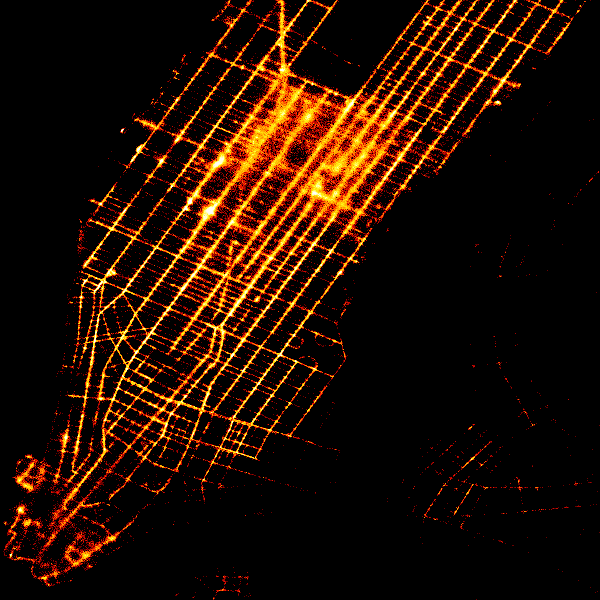

In [9]:
aggregated = datashader.Canvas().points(manhatten_df, 'plon', 'plat')
datashader.tf.set_background(datashader.tf.shade(aggregated, cmap=colorcet.fire), "black")

### Plot dropoff locations in bounding box
Use datashader because it's fast for this many points

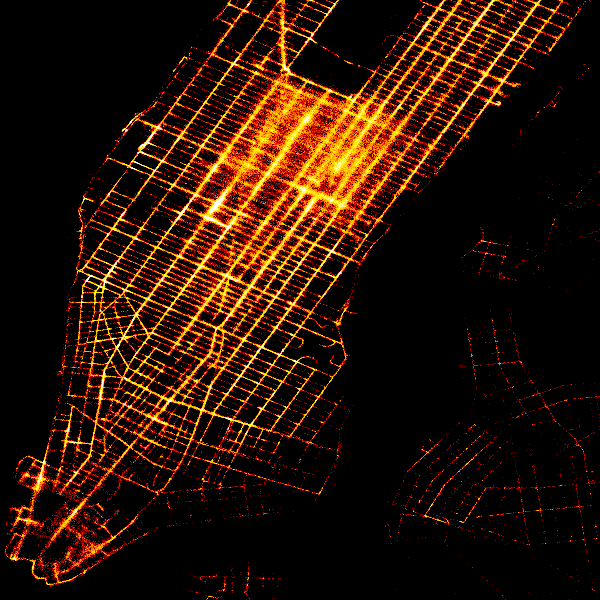

In [10]:
aggregated = datashader.Canvas().points(manhatten_df, 'dlon', 'dlat')
datashader.tf.set_background(datashader.tf.shade(aggregated, cmap=colorcet.fire), "black")

## Graph of Manhatten pickups by the hour

<AxesSubplot: xlabel='pdate', ylabel='count'>

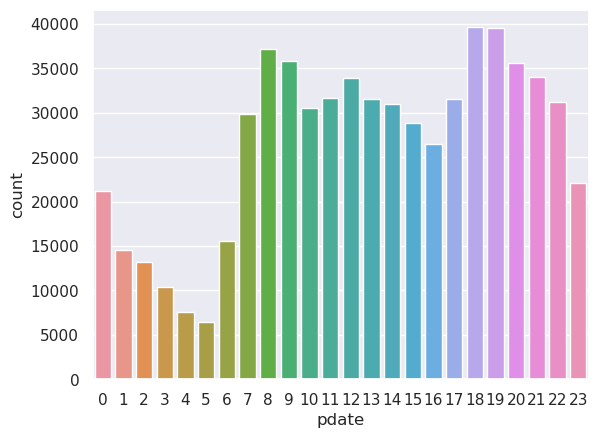

In [11]:
# Convert data to series for easier day/hour retrieval
pickup_dates = manhatten_df['pdate'].squeeze()

# Plot hour of day
seaborn.set()
seaborn.countplot(x=pickup_dates.dt.hour)

## Filter data to JFK airport
Using bounding box coordinates from http://bboxfinder.com/#40.639651,-73.793449,40.650364,-73.775125

In [12]:
xmin,xmax,ymin,ymax = [-73.793449,-73.775125,40.639651,40.650364]
jfk_df = final_gdf[(final_gdf['plat'].between(ymin,ymax)) & 
                   (final_gdf['plon'].between(xmin,xmax)) & 
                   (final_gdf['dlat'].between(ymin,ymax)) & 
                   (final_gdf['dlon'].between(xmin,xmax)) &
                   ((final_gdf['plat'] != final_gdf['dlat']) & 
                    (final_gdf['plon'] != final_gdf['dlon']))]

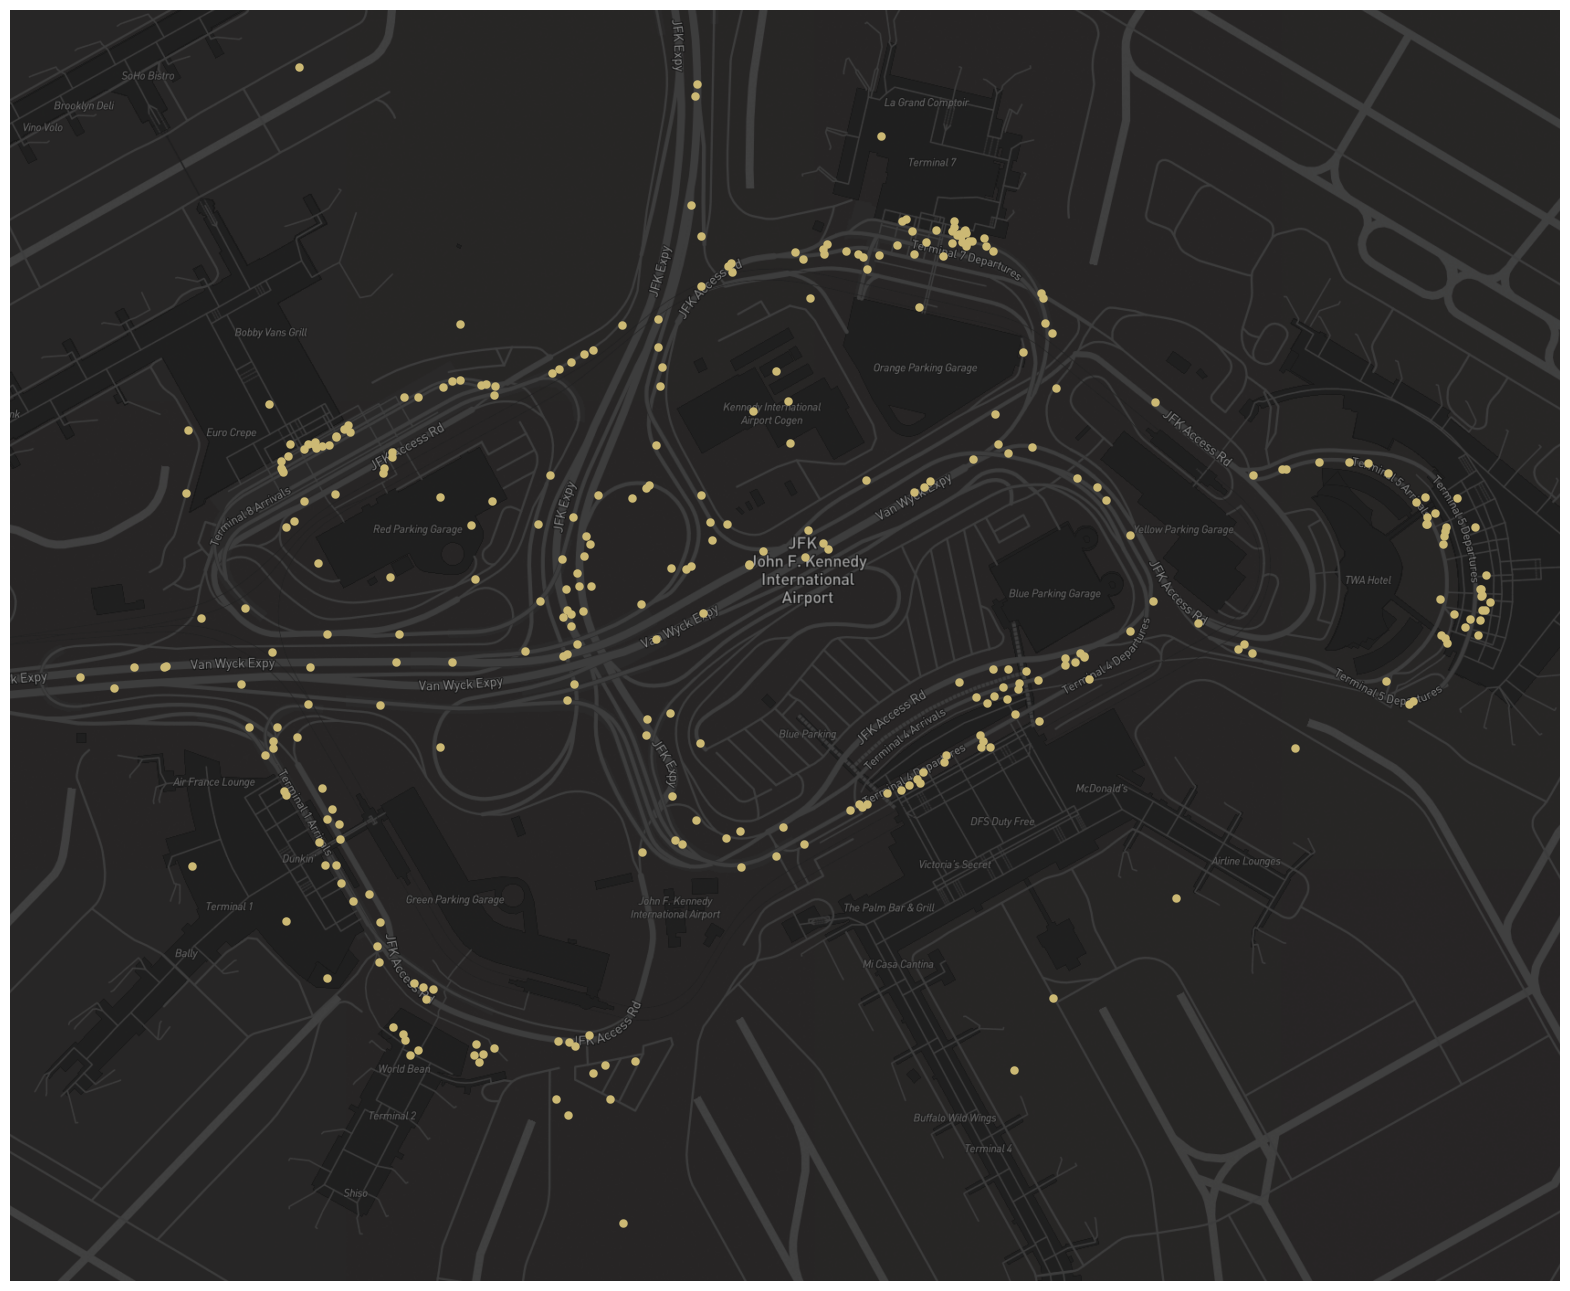

In [13]:
# It's difficult to see so few point using datashader, so switch to contextily
jfk_dropoff_gdf = geopandas.GeoDataFrame(jfk_df, geometry=geopandas.points_from_xy(jfk_df.dlon, jfk_df.dlat), crs=f"EPSG:4326")

# Plot cleaned dropoff locations
ax = jfk_dropoff_gdf.to_crs(epsg=3857).plot(figsize=(20, 20), alpha=1.0, color='y', edgecolor="face", linewidth=0.1)
contextily.add_basemap(ax, source=map_source)
ax.set_axis_off()

### Plot results
Plot a graph to show how many taxi trips had a dropoff location at JFK with more than 2 passengers after 7pm

In [14]:
# Create dataframe where passenger count > 2 and drop off time after 7pm
jfk_dropoff_7pm = jfk_dropoff_gdf[(jfk_dropoff_gdf['passcount'] > 2) & (jfk_dropoff_gdf['ddate'].dt.hour > 19)]

<AxesSubplot: xlabel='ddate', ylabel='count'>

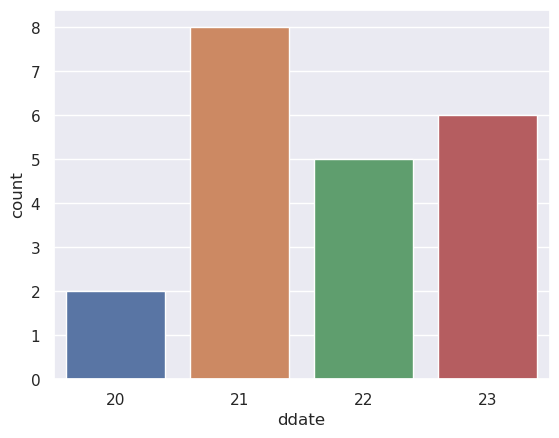

In [15]:
# Convert data to series for easier day/hour retrieval
jfk_dropoff_hour = jfk_dropoff_7pm['ddate'].squeeze()

# Plot count of trips per hour of day
seaborn.countplot(x=jfk_dropoff_hour.dt.hour)

## Convert Lat/Lon to Web Mercator
Using the helper functions from Mansour Raad in the Big Data Class to convert the pickup locations from lat/lon to x/y on the entire cleaned dataframe.

In [16]:
def lon_to_x(lon: pandas.Series) -> pandas.Series:
    return lon * 111319.490793274

def lat_to_y(lat: pandas.Series) -> pandas.Series:
    sin = numpy.sin(numpy.deg2rad(lat))
    return 3189068.5 * numpy.log((1.0 + sin) / (1.0 - sin))

In [17]:
final_gdf['px'] = lon_to_x(final_gdf['plon'])
final_gdf['py'] = lat_to_y(final_gdf['plat'])
final_gdf['dx'] = lon_to_x(final_gdf['dlon'])
final_gdf['dy'] = lat_to_y(final_gdf['dlat'])

## Euclidean Distance

In [18]:
def euclidean_distance(x1:pandas.Series, x2:pandas.Series, y1:pandas.Series, y2:pandas.Series) -> pandas.Series:
    return numpy.sqrt(numpy.square(x2-x1)+numpy.square(y2-y1))

final_gdf['distance_m'] = euclidean_distance(final_gdf['dx'], final_gdf['px'], final_gdf['dy'], final_gdf['py'])

In [19]:
final_gdf[['px', 'py', 'dx', 'dy', 'distance_m']].head()

px            py            dx            dy    distance_m
952377 -8.235030e+06  4.973498e+06 -8.234225e+06  4.950850e+06  22662.506006
851382 -8.234224e+06  4.951525e+06 -8.234224e+06  4.951525e+06      0.000000
360101 -8.236670e+06  4.971624e+06 -8.234236e+06  4.954419e+06  17376.551418
896782 -8.214259e+06  4.960404e+06 -8.234238e+06  4.954441e+06  20849.638914
943336 -8.234078e+06  4.976348e+06 -8.234226e+06  4.954870e+06  21479.070107

## Euclidean Distance Distribution
Plot of records where distance is greater than zero and less than 20,000 m

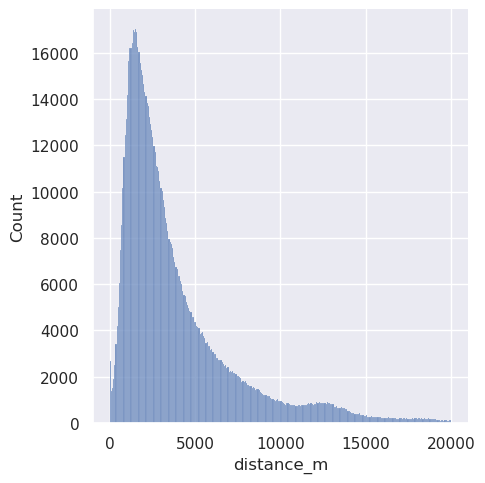

In [20]:
distance_u20 = final_gdf[(final_gdf['distance_m'] > 0) & (final_gdf['distance_m'] < 20000)]
seaborn.displot(distance_u20, x="distance_m")

## Plot distance results on a map, symbolized by trip distance

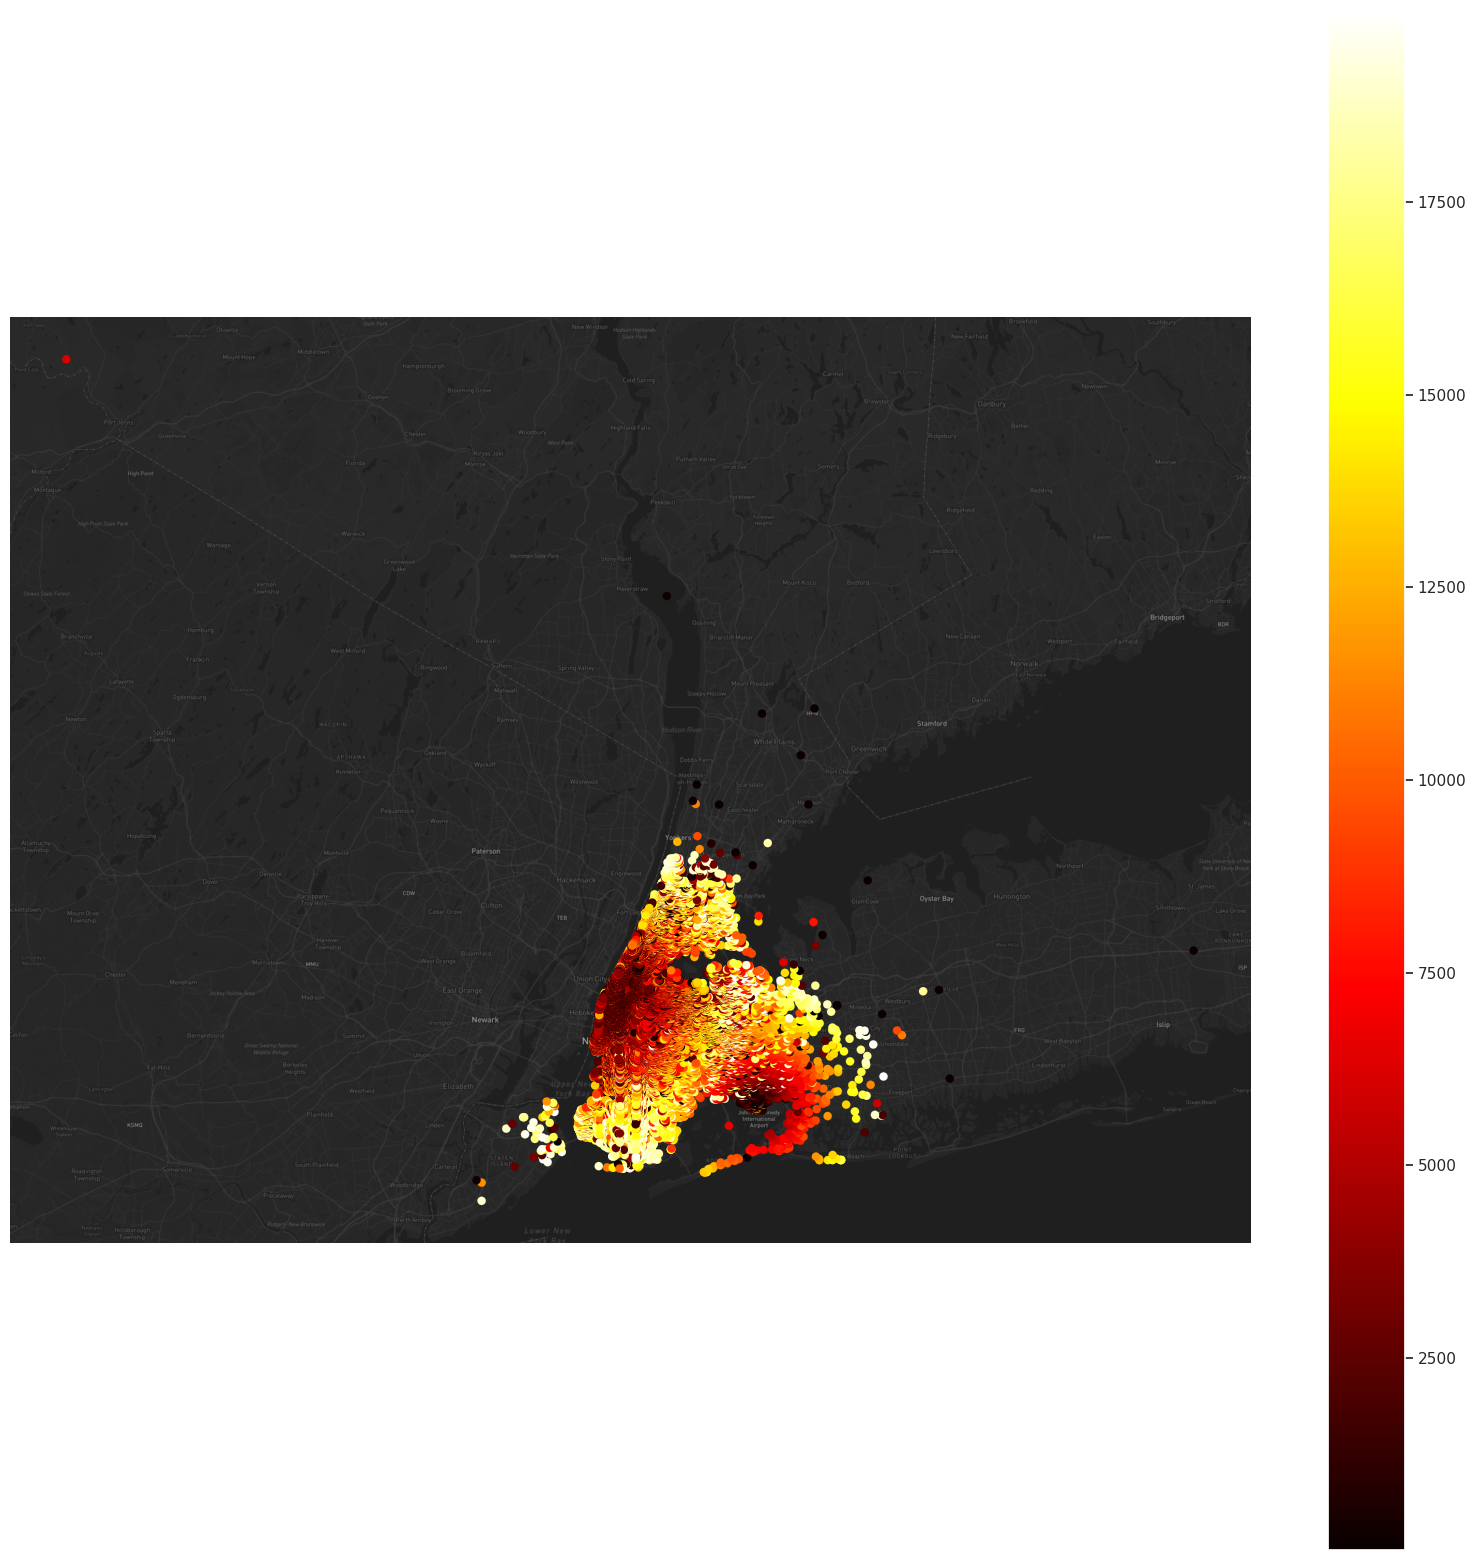

In [21]:
ax = distance_u20.to_crs(epsg=3857).plot(figsize=(20, 20), column='distance_m', alpha=1.0, cmap='hot', legend=True, edgecolor="face", linewidth=0.1)
contextily.add_basemap(ax, source=map_source)
ax.set_axis_off()

## Geo-Enrich data with NY PostCode Boundaries
Using polygon data from here: https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u/data?no_mobile=true

Use geopandas spatial join (inner) to return only the records that are within a zip code.

In [22]:
# Read zip code polygons
nyc_zip_areas = geopandas.read_file('NY_ZIP_CODE.shp', include_fields=['ZIPCODE'])

# Spatial join zip codes to pickup locations
nyc_pickup = geopandas.GeoDataFrame(final_gdf, geometry=geopandas.points_from_xy(final_gdf.plon, final_gdf.plat), crs=f"EPSG:4326")
nyc_pickup_zip = nyc_pickup.sjoin(nyc_zip_areas, how='inner', predicate='intersects')

# Spatial join zip codes to dropoff locations
nyc_dropoff = geopandas.GeoDataFrame(nyc_pickup_zip, geometry=geopandas.points_from_xy(nyc_pickup_zip.dlon, nyc_pickup_zip.dlat), crs=f"EPSG:4326")
nyc_dropoff_zip = nyc_dropoff.sjoin(nyc_zip_areas, how='inner', predicate='intersects', lsuffix='p', rsuffix='d')

In [23]:
nyc_dropoff_zip[['px', 'py', 'dx', 'dy', 'ZIPCODE_p', 'ZIPCODE_d']].head()

px            py            dx            dy ZIPCODE_p  \
952377 -8.235030e+06  4.973498e+06 -8.234225e+06  4.950850e+06     10010   
673211 -8.235924e+06  4.974098e+06 -8.235298e+06  4.950515e+06     10010   
20922  -8.233798e+06  4.952206e+06 -8.234491e+06  4.950643e+06     11223   
669156 -8.213343e+06  4.960092e+06 -8.234139e+06  4.950211e+06     11430   
817722 -8.214248e+06  4.959801e+06 -8.234196e+06  4.949900e+06     11430   

       ZIPCODE_d  
952377     11224  
673211     11224  
20922      11224  
669156     11224  
817722     11224

## Plot Geo-Enriched dropoff records on a map, symbolized by dropoff zip code

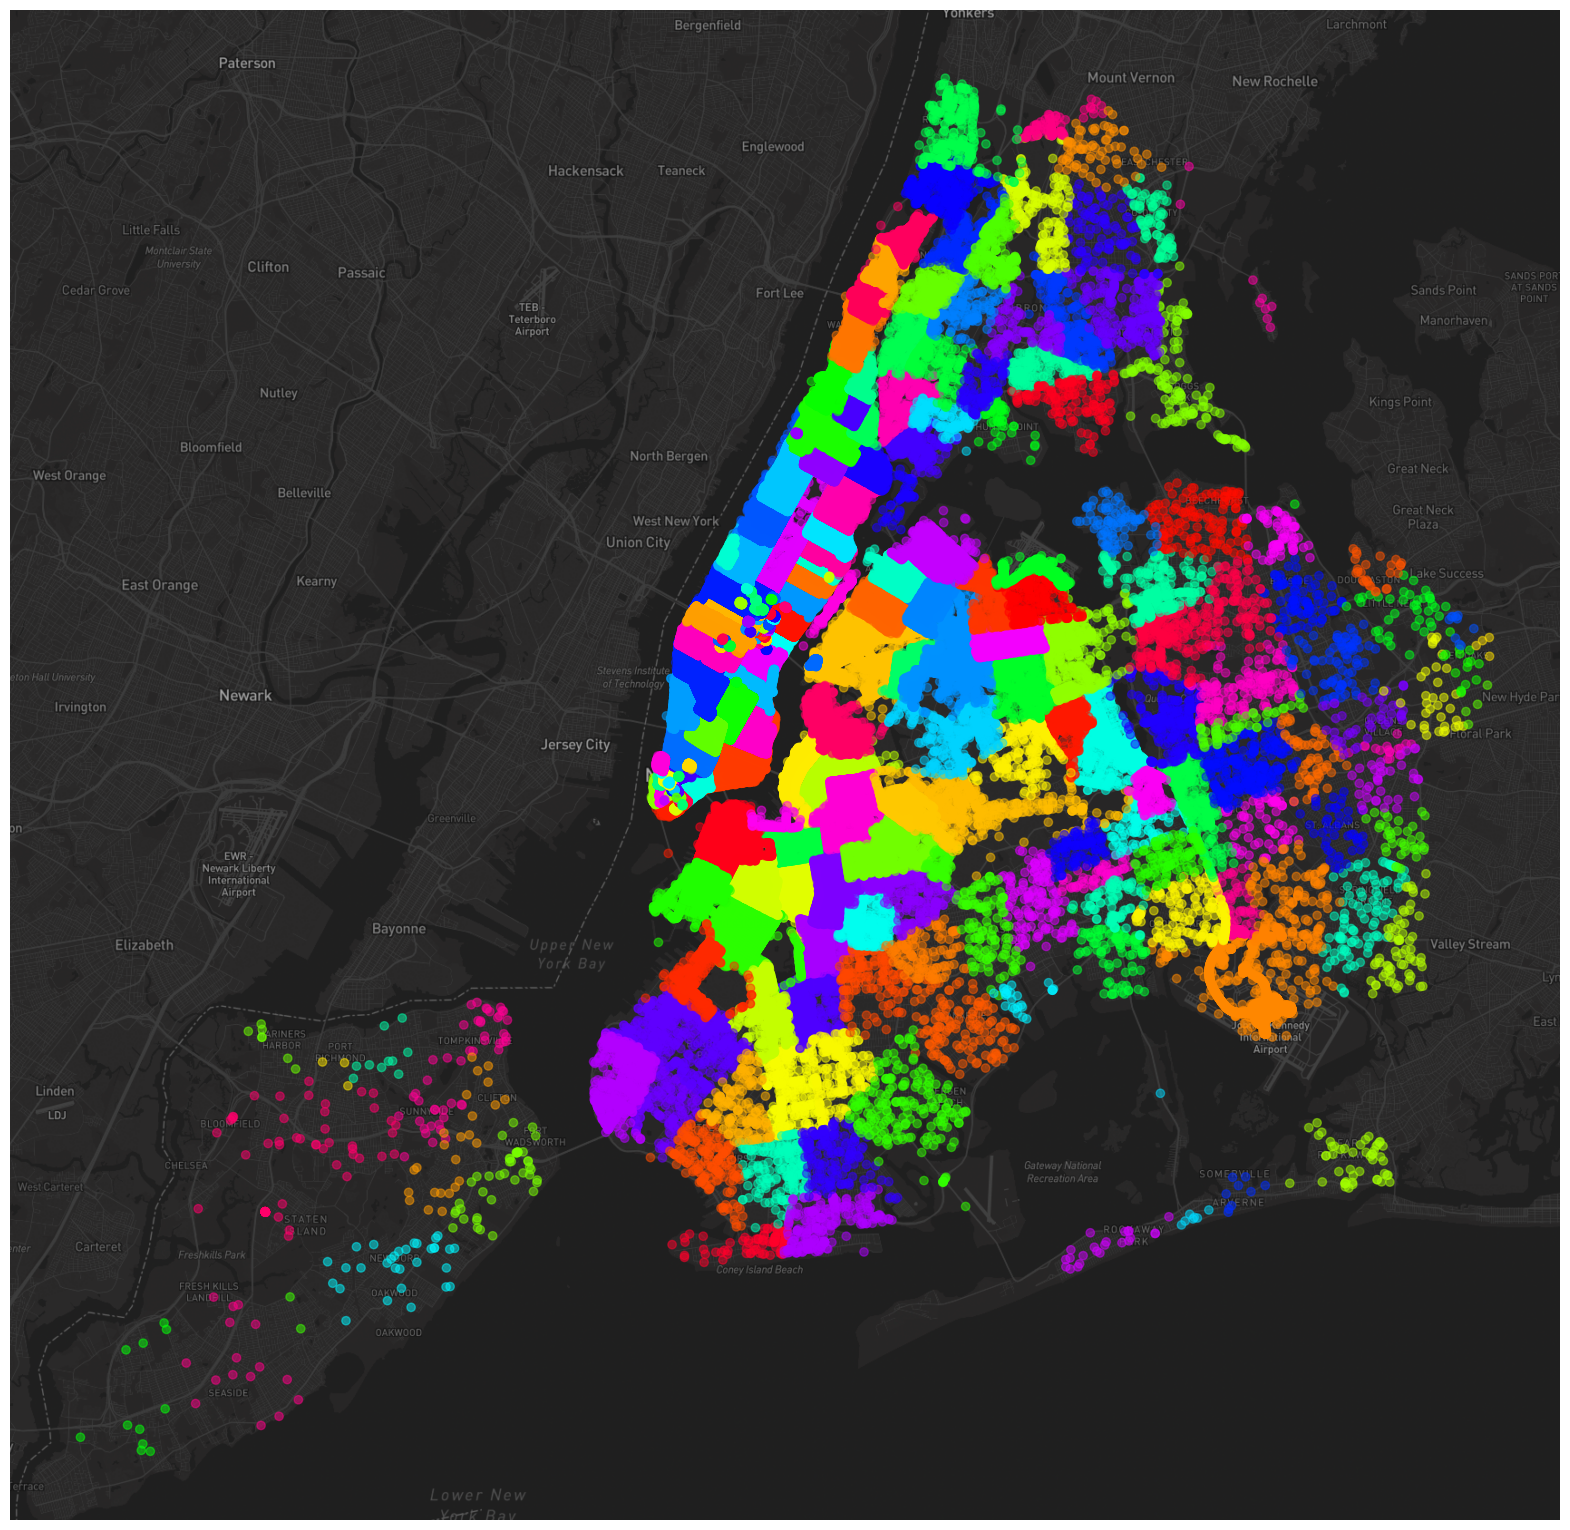

In [24]:
# Shuffle colormap for clearer visualization source: https://gist.github.com/jgomezdans/402500?permalink_comment_id=2264839#gistcomment-2264839
vals = numpy.linspace(0,1,256)
numpy.random.shuffle(vals)
cmap = plt.cm.colors.ListedColormap(plt.cm.hsv(vals))

# Plot dropoff locations symbolized by zip code
ax = nyc_dropoff_zip.to_crs(epsg=3857).plot(figsize=(20, 20), column='ZIPCODE_d', alpha=0.5, cmap=cmap)
contextily.add_basemap(ax, source=map_source)
ax.set_axis_off()